Step 1: Load Libraries and Data

In [160]:
#Import packages
import numpy as np
import pandas as pd
from collections import Counter

# Import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("white")

In [84]:
# File paths
tsv_file = '.\\Participant_data/20240701_Patrick.tsv'
#log_file = '.\\Participant_data/subject-Claudius_log.txt'
#csv_file = '.\\Participant_data/subject-Claudius.csv'

# Load the data
data_tsv = pd.read_csv(tsv_file, sep='\t')
#data_csv = pd.read_csv(csv_file)

Daten bereinigen

In [143]:
first_time_value = data_tsv['TIME'].iloc[0]

data_tsv['TIME'] = data_tsv['TIME'] - first_time_value
#df_valid = data_tsv[data_tsv['BPOGV'] == 1]

#df_valid.shape[0]/data_tsv.shape[0]
# df_fixations =  all Fixations
#df_fixations = data_tsv.groupby('FPOGID')['FPOGX'].median().reset_index()
#df_fixations = data_tsv.groupby('FPOGID')['FPOGX'].mean().reset_index()
df_fixations = data_tsv.groupby('FPOGID').agg({
    'FPOGX': 'median',
    'FPOGY': 'median',
    'TIME': 'median',
    #'USER': 'first'  # Or another method to handle multiple users
}).reset_index()
df_fixations


,FPOGID,FPOGX,FPOGY,TIME
0,9687,0.498370,0.477370,0.227060
1,9688,0.464710,0.319440,0.751715
2,9689,0.507890,0.656160,1.131840
3,9690,0.533600,1.035190,1.358400
4,9691,0.509760,0.325595,1.657475
...,...,...,...,...
429,10116,0.456055,0.429160,351.272950
430,10117,0.553710,0.488560,351.652840
431,10118,0.639710,0.630950,352.057620
432,10119,0.427220,0.363540,352.348150


In [86]:

# #import CSV
# # loop to define,and append the variables into a list.
# df = []
# amt = 4 # The amount of properly labeled tsv files
# for n in range(amt):
#     #d = pd.read_csv(fr'.\\subject-{n+1}.tsv', sep='\t')
#     d = pd.read_csv(fr'.\\Participant_data/subject-Claudius.tsv', sep='\t')
#     #F-strings ('f' before the opening quotation mark) provide a way to embed variables and expressions directly within strings.  
#     df.append(d)
#     #If you want to call subject3 (df3), you can call df[3], if you want df5, call df[5], etc.
#     # Test whether data_tsv is a Pandas dataFrame
#     assert isinstance(df[n], pd.dataFrame) == True

In [87]:
# # Sample subject to visualize (you can change this)
# subject_index = 0  # For example 2, to visualize subject 3

# # Select the relevant data_tsvFrame
# data_tsv = df[subject_index]

In [88]:
#display 5 rows of 1st participant
data_tsv.head()
#TODO BPOGX raw data, FPOGX average (used for fixation of eyetracker)

,CNT,TIME,TIME_TICK,FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,LPOGX,...,LPUPILV,REYEX,REYEY,REYEZ,RPUPILD,RPUPILV,CX,CY,CS,USER
0,567778,0.00000,3555398016176,0.49667,0.46183,5706.43652,0.11328,9687,1,0.49446,...,1,0.06222,0.03155,0.63739,0.00545,1,0.17083,0.5963,0,0
1,567779,0.01661,3555398177730,0.49751,0.46497,5706.43652,0.12988,9687,1,0.49446,...,1,0.06199,0.03182,0.63898,0.00546,1,0.17083,0.5963,0,START_TRIAL
2,567780,0.03223,3555398337705,0.49689,0.46615,5706.43652,0.14551,9687,1,0.48006,...,1,0.06199,0.03182,0.63898,0.00542,1,0.17083,0.5963,0,NaN
3,567781,0.04834,3555398499247,0.49677,0.46721,5706.43652,0.16162,9687,1,0.49025,...,1,0.06199,0.03182,0.63898,0.00541,1,0.17083,0.5963,0,NaN
4,567782,0.06446,3555398658371,0.49665,0.46868,5706.43652,0.17773,9687,1,0.49040,...,1,0.05992,0.03059,0.61807,0.00539,1,0.17083,0.5963,0,NaN


In [89]:
#data_csv.head(5)
print(data_tsv)

          CNT       TIME      TIME_TICK    FPOGX    FPOGY       FPOGS  \
0      567778    0.00000  3555398016176  0.49667  0.46183  5706.43652   
1      567779    0.01661  3555398177730  0.49751  0.46497  5706.43652   
2      567780    0.03223  3555398337705  0.49689  0.46615  5706.43652   
3      567781    0.04834  3555398499247  0.49677  0.46721  5706.43652   
4      567782    0.06446  3555398658371  0.49665  0.46868  5706.43652   
...       ...        ...            ...      ...      ...         ...   
21824  589602  353.01221  3558928134498  0.35739  0.28952  6058.99561   
21825  589603  353.02832  3558928295867  0.35755  0.28951  6058.99561   
21826  589604  353.04395  3558928453853  0.35758  0.28999  6058.99561   
21827  589605  353.06006  3558928615831  0.35759  0.29052  6058.99561   
21828  589606  353.07618  3558928776967  0.35760  0.29094  6058.99561   

         FPOGD  FPOGID  FPOGV    LPOGX  ...  LPUPILV    REYEX    REYEY  \
0      0.11328    9687      1  0.49446  ...      

Step 2: Fixation detection Algorithm + Counting left/right, up/down + counting Coordinates (most near Coordinates of the first Fixation after 'show_stimulus')

Coordinates:
COORDINATES:(-320,0, 320, 0)      
COORDINATES:(-277,-160, 277, 160) 
COORDINATES:(0,320, 0, -320)      
COORDINATES:(277,-160, -277, 160) 
COORDINATES:(-160,-277, 160, 277)
COORDINATES:(160,-277, -160, 277) 
(eventuell mehr nochmal in OpenSesame nachschauen)

In [127]:
# def calculate_velocities(x, y, time):
    
#     # Calculate horizontal and vertical velocities
#     x_vel = np.diff(x)/np.diff(time)
#     y_vel = np.diff(y)/np.diff(time)

#     # Since the velocity is always estimated by at least (in our case exactly) two samples,
#     # the resulting arrays are short by one value.
#     # Therefore we will append a 0 at the beginning of the arrays
#     x_vel = np.insert(x_vel,0,0)
#     y_vel = np.insert(y_vel,0,0)

#     return x_vel, y_vel

# def detect_saccades(x, y, time, threshold=6, n_samples=3):


#     # Calculate horizontal and vertical velocities (using the previously defined function)
#     x_vel, y_vel = calculate_velocities(x, y, time)

#     # Calculate standard deviations of the velocities using the median
#     x_std = np.sqrt(np.median(x_vel**2)-np.median(x_vel)**2)
#     y_std = np.sqrt(np.median(y_vel**2)-np.median(y_vel)**2)

#     # Scale the velocity by their respective standard deviations to get a common scale
#     x_vel_norm = x_vel/x_std
#     y_vel_norm = y_vel/y_std
    
#     # Check which samples pass the velocity threshold
#     vel_above_t = np.sqrt((x_vel_norm)**2 + (y_vel_norm)**2) > threshold
    
#     ####################################################################
#     # Alternative solution:
#     #radius_x = x_std*threshold
#     #radius_y = y_std*threshold
    
#     # Check which samples pass the velocity threshold
#     #vel_above_t = (x_vel/radius_x)**2 +  (y_vel/radius_y)**2 > 1
#     ####################################################################
    
#     # Initialize dict to save the saccade start and end indices
#     sacc_times = {"sacc_start_idx":[], "sacc_end_idx":[]}

#     # Find start and end index of a saccade (under the condition that it has to be at least n samples long)
#     idx = 0
#     while idx <= len(vel_above_t)- n_samples:
#         # If at least n samples pass the velocity threshold
#         # note the starting index for the saccade
#         if np.sum(vel_above_t[idx:idx+n_samples]) == n_samples:
#             sacc_times["sacc_start_idx"].append(idx)
            
#             # Add samples to the saccade as long as they pass the threshold (and the end of the trial is not reached)
#             j = idx + n_samples
#             while (j < len(vel_above_t)) and (vel_above_t[j]==1):
#                 j += 1

#             sacc_times["sacc_end_idx"].append(j-1)
#             idx = j

#         else:
#             idx+=1
    
#     return sacc_times

# results_vel = detect_saccades(data_tsv["FPOGX"],data_tsv["FPOGY"],data_tsv["TIME"],threshold=6,n_samples=3)
# results_vel_df = pd.DataFrame(results_vel)
# print(results_vel_df)




In [128]:
# def infer_other_event_df(given_type,results_df,samples_df):
    
#     # determined the other (desired) event type based on the given event type
#     other_type = ["fix" if given_type=="sacc" else "sacc"][0]

#     # Label samples in between events from one class (e.g. saccades) as events from the other class (e.g. fixations)
#     other_type_start_idx = results_df.loc[:results_df.last_valid_index()-1,"{}_end_idx".format(given_type)].values+1
#     other_type_end_idx = results_df.loc[1:,"{}_start_idx".format(given_type)].values-1
    
#     other_results_df = pd.DataFrame({"{}_start_idx".format(other_type):other_type_start_idx,"{}_end_idx".format(other_type):other_type_end_idx})
    
#     # Filter out cases where the end index would be smaller than the start index (i.e. cases where neighbouring events are of the same type)
#     other_results_df = other_results_df[other_results_df["{}_end_idx".format(other_type)]- other_results_df["{}_start_idx".format(other_type)] >= 0]
    
#     # Check whether there are samples before the first or after the last event in the given data frame
#     offset_start = results_df["{}_start_idx".format(given_type)].iloc[0]-samples_df.index[0]
#     offset_end = samples_df.index[-1]-results_df["{}_end_idx".format(given_type)].iloc[-1]
    
#     # If there are samples before or after the events from the given class (e.g. saccades) label them as belonging to the other class (e.g. fixations)
#     if offset_start>0:
#         other_results_df_temp = pd.DataFrame({"{}_start_idx".format(other_type):[samples_df.index[0]],
#                                               "{}_end_idx".format(other_type):[results_df["{}_start_idx".format(given_type)].iloc[0]-1]})
#         other_results_df = pd.concat([other_results_df_temp,other_results_df], ignore_index=True)

#     if offset_end>0:
#         other_results_df_temp = pd.DataFrame({"{}_start_idx".format(other_type):[results_df["{}_end_idx".format(given_type)].iloc[-1]+1],
#                                               "{}_end_idx".format(other_type):[samples_df.index[-1]]})
#         other_results_df = pd.concat([other_results_df,other_results_df_temp], ignore_index=True)
    
#     return other_results_df


# esults_vel_df_fix = infer_other_event_df("sacc",results_vel_df,data_tsv)
# endresults_vel_df = pd.DataFrame(esults_vel_df_fix)



# print(endresults_vel_df)

In [126]:
# endresults_vel_df_fix = infer_other_event_df("sacc",results_vel_df,data_tsv)

# # Extract the start and end times
# endresults_vel_df_fix["fix_start"] = data_tsv["TIME"].iloc[endresults_vel_df_fix["fix_start_idx"]].values
# endresults_vel_df_fix["fix_end"] = data_tsv["TIME"].iloc[endresults_vel_df_fix["fix_end_idx"]].values

# # Compute the fixation durations
# endresults_vel_df_fix["fix_dur"] = endresults_vel_df_fix["fix_end"] - endresults_vel_df_fix["fix_start"]

# endresults_vel_df_fix

In [93]:
#fixation_events = data_tsv[data_tsv['TIME'].isin(endresults_vel_df_fix['fix_end'])][['TIME', 'FPOGX', 'FPOGY','USER']]


Filter Fixation Events

In [94]:
#fixation_events = data_tsv[data_tsv['USER'] == 'SHOW_STIMULUS'][['TIME', 'FPOGX', 'FPOGY']]

Convert Coordinates

In [157]:
screen_width = 1920
screen_height = 1080

df_fixations['x_coord'] = (df_fixations['FPOGX'] - 0.5) * screen_width
df_fixations['y_coord'] = (df_fixations['FPOGY'] - 0.5) * screen_height

#Define Target Coordinates
target_coords = [
    (-320, 0), (320, 0), (-277, -160), (277, 160), 
    (0, 320), (0, -320), (277, -160), (-277, 160), 
    (-160, -277), (160, 277), (160, -277), (-160, 277)
]

df_fixations

,FPOGID,FPOGX,FPOGY,TIME,x_coord,y_coord
0,9687,0.498370,0.477370,0.227060,-3.1296,-24.4404
1,9688,0.464710,0.319440,0.751715,-67.7568,-195.0048
2,9689,0.507890,0.656160,1.131840,15.1488,168.6528
3,9690,0.533600,1.035190,1.358400,64.5120,578.0052
4,9691,0.509760,0.325595,1.657475,18.7392,-188.3574
...,...,...,...,...,...,...
429,10116,0.456055,0.429160,351.272950,-84.3744,-76.5072
430,10117,0.553710,0.488560,351.652840,103.1232,-12.3552
431,10118,0.639710,0.630950,352.057620,268.2432,141.4260
432,10119,0.427220,0.363540,352.348150,-139.7376,-147.3768


In [149]:
df_fixations

,FPOGID,FPOGX,FPOGY,TIME
0,9687,0.498370,0.477370,0.227060
1,9688,0.464710,0.319440,0.751715
2,9689,0.507890,0.656160,1.131840
3,9690,0.533600,1.035190,1.358400
4,9691,0.509760,0.325595,1.657475
...,...,...,...,...
429,10116,0.456055,0.429160,351.272950
430,10117,0.553710,0.488560,351.652840
431,10118,0.639710,0.630950,352.057620
432,10119,0.427220,0.363540,352.348150


In [163]:
# Threshold distance
threshold = 100  # Change this value as needed

# Function to check if the fixation is within the threshold distance from any target coordinate
def is_within_threshold(row, target_coords, threshold):
    x, y = row['x_coord'], row['y_coord']
    for tx, ty in target_coords:
        if np.sqrt((x - tx)**2 + (y - ty)**2) <= threshold:
            return True
    return False

# Find the indices of 'SHOW_STIMULUS' events
show_stimulus_times = data_tsv[data_tsv['USER'] == 'SHOW_STIMULUS']['TIME'].values
show_stimulus_times



array([  3.47754,  10.80469,  18.03516,  25.23243,  32.41456,  39.57959,
        46.74512,  53.99073,  61.41504,  68.58008,  75.7461 ,  82.99219,
        90.18995,  97.3877 , 104.63379, 112.30079, 119.54688, 126.89063,
       134.15235, 141.43116, 148.56397, 155.7461 , 162.84668, 169.94678,
       177.14502, 184.24512, 191.87989, 199.44971, 207.97364, 215.13916,
       222.25586, 229.40479, 236.55469, 243.75196, 250.90137, 258.08252,
       265.21631, 272.55909, 280.61426, 287.86036, 295.6084 , 303.59815,
       310.84571, 318.02588, 325.32081, 332.46973, 340.18506, 347.94922])

In [161]:
# Threshold distance
threshold = 50  # Change this value as needed

# Function to find the closest target coordinate within the threshold distance
def find_closest_target(row, target_coords, threshold):
    x, y = row['x_coord'], row['y_coord']
    for tx, ty in target_coords:
        if np.sqrt((x - tx)**2 + (y - ty)**2) <= threshold:
            return (tx, ty)
    return None

# Get the 'TIME' values for each 'SHOW_STIMULUS' event from data_tsv
show_stimulus_times = data_tsv[data_tsv['USER'] == 'SHOW_STIMULUS']['TIME'].values

# Initialize a list to store the target coordinates of first fixations
first_fixation_targets = []

# Iterate over each 'SHOW_STIMULUS' event time
for show_time in show_stimulus_times:
    # Filter fixations that occur after the 'SHOW_STIMULUS' event time
    valid_fixations = df_fixations[df_fixations['TIME'] > show_time]
    
    # Find the first fixation within the threshold distance
    for idx, row in valid_fixations.iterrows():
        target = find_closest_target(row, target_coords, threshold)
        if target:
            first_fixation_targets.append(target)
            break

# Count the occurrences of each target coordinate
target_counts = Counter(first_fixation_targets)

# Print the results
print("Counts of each target coordinate being looked at first:")
for coord, count in target_counts.items():
    print(f"Coordinate {coord}: {count} times")

# Optionally, you can convert the counts to a DataFrame for better visualization
target_counts_df = pd.DataFrame(list(target_counts.items()), columns=['Coordinate', 'Count'])
print(target_counts_df)


Counts of each target coordinate being looked at first:
Coordinate (-277, -160): 6 times
Coordinate (-160, -277): 7 times
Coordinate (-160, 277): 3 times
Coordinate (277, -160): 4 times
Coordinate (-320, 0): 6 times
Coordinate (0, 320): 2 times
Coordinate (0, -320): 5 times
Coordinate (320, 0): 2 times
Coordinate (160, -277): 6 times
Coordinate (-277, 160): 4 times
Coordinate (160, 277): 1 times
Coordinate (277, 160): 2 times
      Coordinate  Count
0   (-277, -160)      6
1   (-160, -277)      7
2    (-160, 277)      3
3    (277, -160)      4
4      (-320, 0)      6
5       (0, 320)      2
6      (0, -320)      5
7       (320, 0)      2
8    (160, -277)      6
9    (-277, 160)      4
10    (160, 277)      1
11    (277, 160)      2


In [158]:
# Initialize a list to store the first fixations
first_fixations = []

# Iterate over each 'SHOW_STIMULUS' event time
for show_time in show_stimulus_times:
    # Filter fixations that occur after the 'SHOW_STIMULUS' event time
    valid_fixations = df_fixations[df_fixations['TIME'] > show_time]
    
    # Find the first fixation within the threshold distance
    for idx, row in valid_fixations.iterrows():
        if is_within_threshold(row, target_coords, threshold):
            first_fixations.append(row)
            break

# Convert the list of first fixations to a DataFrame
first_fixations_df = pd.DataFrame(first_fixations)

# Count the first fixations
first_fixation_count = first_fixations_df.shape[0]

# Print the result
print(f"The number of first fixations on target coordinates within a {threshold} unit threshold after 'SHOW_STIMULUS' events is: {first_fixation_count}")

The number of first fixations on target coordinates within a 100 unit threshold after 'SHOW_STIMULUS' events is: 48


#Find first Fixation

In [96]:
stimulus_time = data_tsv[data_tsv['event'] == 'FIXATION_STIMULUS']['time'].iloc[0]
first_target_fixation = fixation_events[(fixation_events['RecordingTimestamp'] > stimulus_time) & 
                                        fixation_events.apply(lambda row: any((abs(row['x_coord'] - x) <= threshold and abs(row['y_coord'] - y) <= threshold) for x, y in target_coords), axis=1)].iloc[0]

KeyError: 'event'

In [ ]:
def find_first_fixation_after(event_time, fixations, target_coords, threshold=50):
    for index, row in fixations.iterrows():
        if row['fix_start'] > event_time:
            for coord in target_coords:
                if abs(row['x_coord'] - coord[0]) <= threshold and abs(row['y_coord'] - coord[1]) <= threshold:
                    return row
    return None

first_fixations = fixation_events['TIME'].apply(lambda time: find_first_fixation_after(time, endresults_vel_df_fix, target_coords))
print(first_fixations.head())


KeyError: 'x_coord'

In [ ]:
regions = [
    {'name': 'region1', 'bounds': (-320, 0, 320, 0)},
    {'name': 'region2', 'bounds': (-277, -160, 277, 160)},
    {'name': 'region3', 'bounds': (0, 320, 0, -320)},
    {'name': 'region4', 'bounds': (277, -160, -277, 160)},
    {'name': 'region5', 'bounds': (-160, -277, 160, 277)},
    {'name': 'region6', 'bounds': (160, -277, -160, 277)},
]

def count_fixations_in_regions(fixations, data_tsv, regions):
    counts = {region['name']: 0 for region in regions}

    for _, row in fixations.iterrows():
        mean_x = data_tsv.loc[row['fix_start_idx']:row['fix_end_idx'], 'FPOGX'].mean()
        mean_y = data_tsv.loc[row['fix_start_idx']:row['fix_end_idx'], 'FPOGY'].mean()

        for region in regions:
            x1, y1, x2, y2 = region['bounds']
            if x1 <= mean_x <= x2 and y1 <= mean_y <= y2:
                counts[region['name']] += 1

    return counts

fixation_counts = count_fixations_in_regions(endresults_vel_df, data_tsv, regions)


In [97]:
def find_first_fixation_after_event(data_tsv, fixations, event_name='START_TRIAL'):
    event_time = None
    for _, row in data_tsv.iterrows():
        if row['USER'] == event_name:
            event_time = row['TIME']
            break

    if event_time is None:
        return None

    for _, row in fixations.iterrows():
        if data_tsv.loc[row['fix_start_idx'], 'TIME'] >= event_time:
            return row

    return None

first_fixation = find_first_fixation_after_event(data_tsv, endresults_vel_df)


In [98]:
def find_nearest_coordinate(fixation, data_tsv, coordinates):
    if fixation is None:
        return None

    mean_x = data_tsv.loc[fixation['fix_start_idx']:fixation['fix_end_idx'], 'FPOGX'].mean()
    mean_y = data_tsv.loc[fixation['fix_start_idx']:fixation['fix_end_idx'], 'FPOGY'].mean()

    nearest_coord = None
    min_distance = float('inf')

    for coord in coordinates:
        x1, y1, x2, y2 = coord
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        distance = ((mean_x - center_x) ** 2 + (mean_y - center_y) ** 2) ** 0.5
        if distance < min_distance:
            min_distance = distance
            nearest_coord = coord

    return nearest_coord

coordinates = [
    (-320, 0, 320, 0),
    (-277, -160, 277, 160),
    (0, 320, 0, -320),
    (277, -160, -277, 160),
    (-160, -277, 160, 277),
    (160, -277, -160, 277),
]

nearest_coord = find_nearest_coordinate(first_fixation, data_tsv, coordinates)
print(nearest_coord)  # Print the nearest coordinate to verify

(-320, 0, 320, 0)


In [ ]:
print("Fixation Detection Completed")
print(results_disp_df)  # Print first few rows of fixations to verify

print("Fixations Counted in Regions")
print(fixation_counts)  # Print the counts to verify

print("First Fixation After 'START_TRIAL'")
print(first_fixation)  # Print the first fixation details to verify

print("Nearest Coordinate to First Fixation")
print(nearest_coord)  # Print the nearest coordinate to verify

Fixation Detection Completed


NameError: name 'results_disp_df' is not defined

In [99]:
def count_fixations_in_coordinate_pairs(fixations, data_tsv, coordinates):
    counts = {
        'oben_links': 0,
        'oben_rechts': 0,
        'unten_links': 0,
        'unten_rechts': 0,
        'diagonal_links': 0,
        'diagonal_rechts': 0,
    }

    for _, row in fixations.iterrows():
        mean_x = data_tsv.loc[row['fix_start_idx']:row['fix_end_idx'], 'FPOGX'].mean()
        mean_y = data_tsv.loc[row['fix_start_idx']:row['fix_end_idx'], 'FPOGY'].mean()

        for coord in coordinates:
            x1, y1, x2, y2 = coord
            center_x = (x1 + x2) / 2
            center_y = (y1 + y2) / 2

            if mean_y <= center_y:  # oben
                if mean_x <= center_x:  # links
                    counts['oben_links'] += 1
                else:  # rechts
                    counts['oben_rechts'] += 1
            else:  # unten
                if mean_x <= center_x:  # links
                    counts['unten_links'] += 1
                else:  # rechts
                    counts['unten_rechts'] += 1

            # Check diagonal conditions
            if (mean_x - center_x) * (mean_y - center_y) < 0:  # diagonal
                if mean_x <= center_x:  # links
                    counts['diagonal_links'] += 1
                else:  # rechts
                    counts['diagonal_rechts'] += 1

    return counts

# Beispiel für Koordinaten (bitte entsprechend anpassen, falls notwendig)
coordinates = [
    (-320, 0, 320, 0),     # horizontal zentriert
    (-277, -160, 277, 160), # horizontal in der Mitte
    (0, 320, 0, -320),     # vertikal zentriert
    (277, -160, -277, 160), # vertikal in der Mitte
    (-160, -277, 160, 277), # diagonal links unten
    (160, -277, -160, 277), # diagonal rechts oben
]

# Annahme: results_disp_df ist ein DataFrame mit den Ergebnissen der Fixation Detection
# und data_tsv ist der ursprüngliche DataFrame mit den Eyetracking-Daten

# Zähle Fixierungen in Paaren von Koordinatenbereichen
pair_fixation_counts = count_fixations_in_coordinate_pairs(results_disp_df, data_tsv, coordinates)

# Drucke die Zählungen für jedes Paar
print("Fixierungen gezählt in Paaren von Koordinatenbereichen")
print(pair_fixation_counts)




NameError: name 'results_disp_df' is not defined

(Step 2: Load and Parse Log Data (irrelevant))

In [ ]:
# # Load log data
# with open(log_file, 'r') as file:
#     log_data = file.readlines()

# # Parse log data
# logs = []
# for line in log_data:
#     if "start_trial" in line or "stop_trial" in line or "coordinates" in line:
#         logs.append(line.strip())
        
# # Create DataFrame for logs
# log_df = pd.DataFrame(logs, columns=['log'])

# # Function to extract timestamps and other details from logs
# def extract_log_details(log_df):
#     events = []
#     for index, row in log_df.iterrows():
#         if "start_trial" in row['log']:
#             events.append({'timestamp': index, 'event': 'start_trial'})
#         elif "stop_trial" in row['log']:
#             events.append({'timestamp': index, 'event': 'stop_trial'})
#         elif "coordinates" in row['log']:
#             coords = row['log'].split(':')[1].strip()
#             events.append({'timestamp': index, 'event': 'coordinates', 'coords': coords})
#     return pd.DataFrame(events)

# # Extracting log details
# log_events = extract_log_details(log_df)
# log_events.head()

Step 3: Different Plots

Step 3.1: Distribution of FPOGX

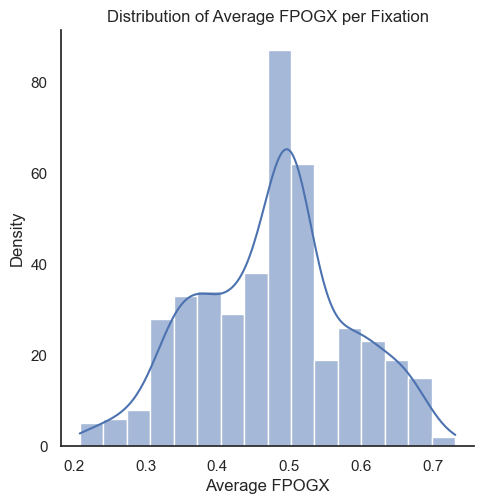

In [100]:


# Plot the distribution using seaborn's displot
sns.displot(df_fixations, x='FPOGX', kde=True) 
plt.title('Distribution of Average FPOGX per Fixation')
plt.xlabel('Average FPOGX')
plt.ylabel('Density')
plt.show()

In [111]:
df_fixations

,FPOGID,FPOGX
0,9687,0.496007
1,9688,0.352535
2,9689,0.520695
3,9690,0.534394
4,9691,0.282693
...,...,...
429,10116,0.463561
430,10117,0.568174
431,10118,0.592627
432,10119,0.422048


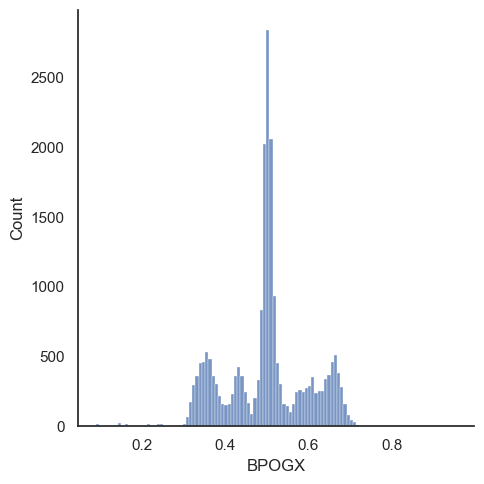

In [101]:
#test the dataset with a displot
#Use FPOGID instead of count to get Valid Counts (One fixation gets many counts)
sns.displot(data_tsv, x='BPOGX')

Step 3.2: Plot Time Against X-Position with Vertical Lines for Each User Log/Trigger

In [ ]:
# Filter the data_tsv for different event types
show_stimulus_points = data_tsv[data_tsv['USER'] == 'SHOW_STIMULUS']
start_trial_points = data_tsv[data_tsv['USER'] == 'START_TRIAL']
stop_trial_points = data_tsv[data_tsv['USER'] == 'STOP_TRIAL']
start_sequence_points = data_tsv[data_tsv['USER'] == 'START_SEQUENCE']
stop_sequence_points = data_tsv[data_tsv['USER'] == 'STOP_SEQUENCE']

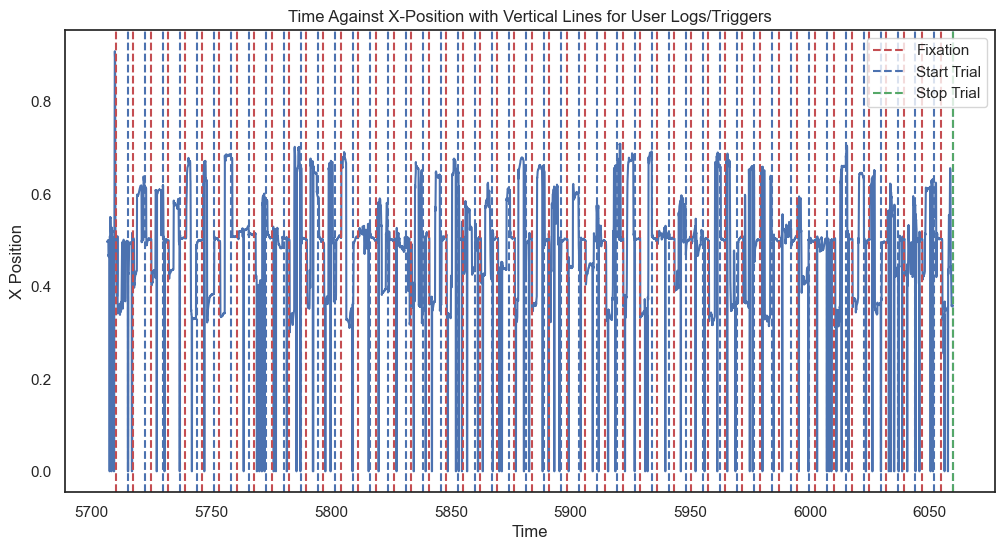

In [ ]:

# **Time vs. X Plot**
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_tsv, x="TIME", y="FPOGX")
plt.title('Time Against X-Position with Vertical Lines for User Logs/Triggers')
plt.xlabel("Time")
plt.ylabel("X Position")
#plt.xlim(3500, 3600)

# Filter the data_tsv for different event types
fixation_times = data_tsv[data_tsv['USER'] == 'SHOW_STIMULUS']['TIME']
start_trial_times = data_tsv[data_tsv['USER'] == 'HIDE_STIMULUS']['TIME']
stop_trial_times = data_tsv[data_tsv['USER'] == 'STOP_TRIAL']['TIME']
stimuli_times = data_tsv[data_tsv['USER'] == 'STIMULI']['TIME']
coordinates_times = data_tsv[data_tsv['USER'] == 'COORDINATES']['TIME']

# Add vertical lines for each event type
for fixation_time in fixation_times:
    plt.axvline(x=fixation_time, color='r', linestyle='--', label='Fixation' if fixation_time == fixation_times.iloc[0] else "")
for start_trial_time in start_trial_times:
    plt.axvline(x=start_trial_time, color='b', linestyle='--', label='Start Trial' if start_trial_time == start_trial_times.iloc[0] else "")
for stop_trial_time in stop_trial_times:
    plt.axvline(x=stop_trial_time, color='g', linestyle='--', label='Stop Trial' if stop_trial_time == stop_trial_times.iloc[0] else "")
for stimuli_time in stimuli_times:
    plt.axvline(x=stimuli_time, color='m', linestyle='--', label='Stimuli' if stimuli_time == stimuli_times.iloc[0] else "")
for coordinates_time in coordinates_times:
    plt.axvline(x=coordinates_time, color='y', linestyle='--', label='Coordinates' if coordinates_time == coordinates_times.iloc[0] else "")

# Add a legend
plt.legend()

plt.show()
#TODO: X und Y in einen Plot


In [ ]:
# # **Time vs. X Plot**
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=data_tsv, x="TIME", y="FPOGX")
# plt.title('Time Against X-Position with Vertical Lines for User Logs/Triggers')
# plt.xlabel("Time")
# plt.ylabel("X Position")

# # Add vertical lines for each user log/trigger
# for trigger_time in data_csv['time_image_stimulus']:
#  plt.axvline(x=trigger_time, color='r', linestyle='--')
# plt.show()

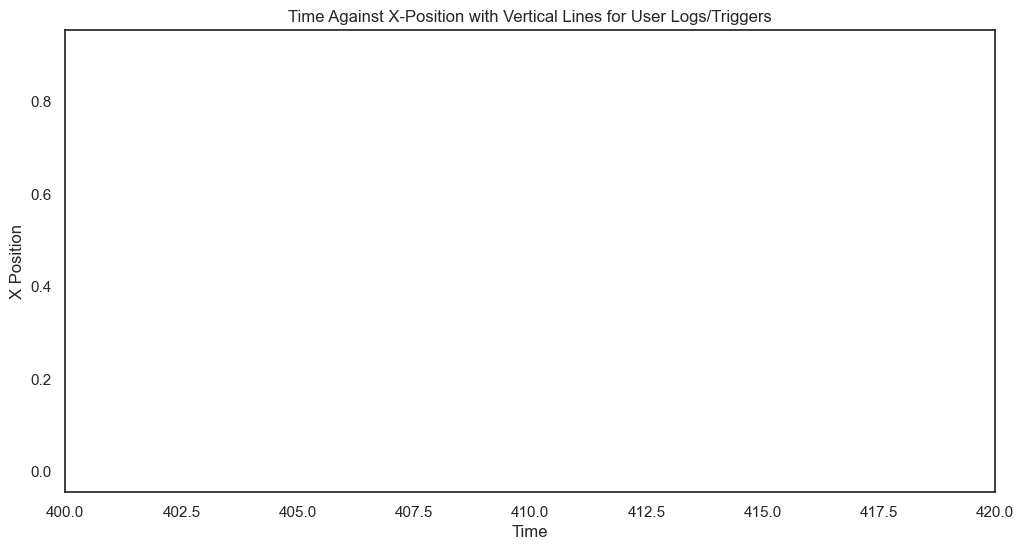

In [ ]:
# **Time vs. X Plot**
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_tsv, x="TIME", y="FPOGX")
plt.title('Time Against X-Position with Vertical Lines for User Logs/Triggers')
plt.xlabel("Time")
plt.ylabel("X Position")
plt.xlim(400, 420)
# Filter the data_tsv for rows where USER column is 'FIXATION'
fixation_times = data_tsv[data_tsv['USER'] == 'FIXATION_STIMULUS']['TIME']

# Add vertical lines for each fixation time
for fixation_time in fixation_times:
    plt.axvline(x=fixation_time, color='r', linestyle='--')
plt.show()

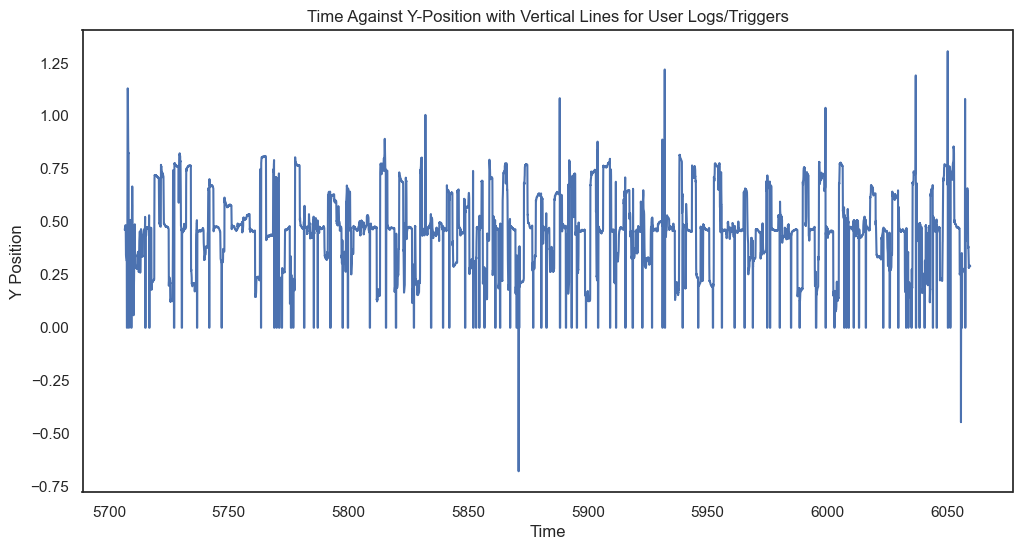

In [ ]:
# **Time vs. Y Plot**
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_tsv, x="TIME", y="FPOGY")
plt.title('Time Against Y-Position with Vertical Lines for User Logs/Triggers')
plt.xlabel("Time")
plt.ylabel("Y Position")
# Filter the data_tsv for rows where USER column is 'FIXATION'
fixation_times = data_tsv[data_tsv['USER'] == 'FIXATION']['TIME']

# Add vertical lines for each fixation time
for fixation_time in fixation_times:
    plt.axvline(x=fixation_time, color='r', linestyle='--')
plt.show()

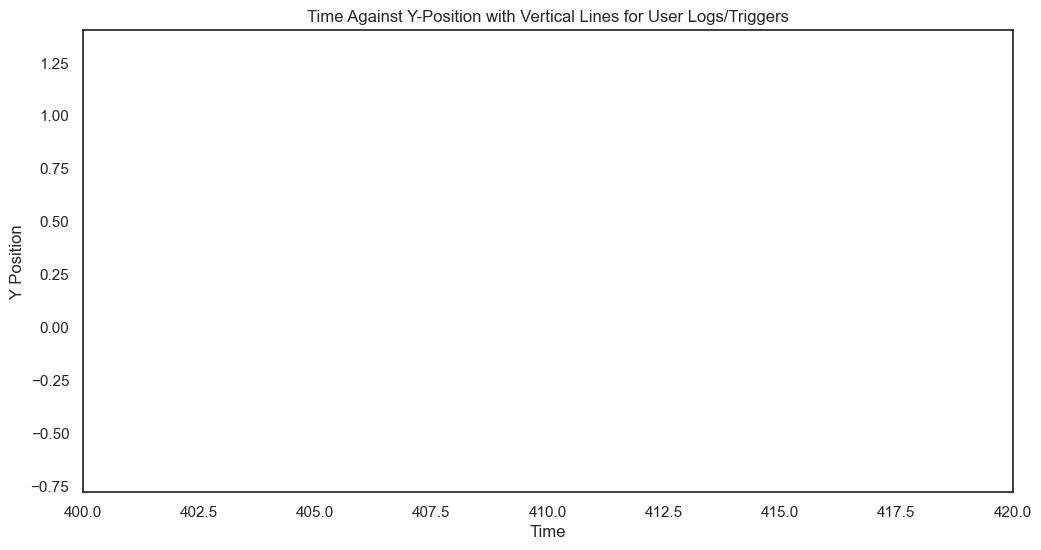

In [ ]:
# **Time vs. Y Plot**
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_tsv, x="TIME", y="FPOGY")
plt.title('Time Against Y-Position with Vertical Lines for User Logs/Triggers')
plt.xlabel("Time")
plt.ylabel("Y Position")
plt.xlim(400, 420)
# Filter the data_tsv for rows where USER column is 'FIXATION'
fixation_times = data_tsv[data_tsv['USER'] == 'FIXATION_STIMULUS']['TIME']

# Add vertical lines for each fixation time
for fixation_time in fixation_times:
    plt.axvline(x=fixation_time, color='r', linestyle='--')
plt.show()

In [ ]:
# # **Time vs. Y Plot** zoom in
# sns.lineplot(data=data_tsv, x="TIME", y="FPOGY")
# # Zoom in on the x-axis between 0.6 and 0.7
# plt.xlim(3550, 3600)
# plt.title(f"Subject {subject_index + 1} - Y Position over Time")
# plt.xlabel("Time")
# plt.ylabel("Y Position")
# plt.show()

C:\Users\EnnÖ\AppData\Local\Temp\ipykernel_5052\3281921735.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(fixation_events['FPOGX'], fixation_events['FPOGY'], c=colors, cmap='viridis', marker='o')


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

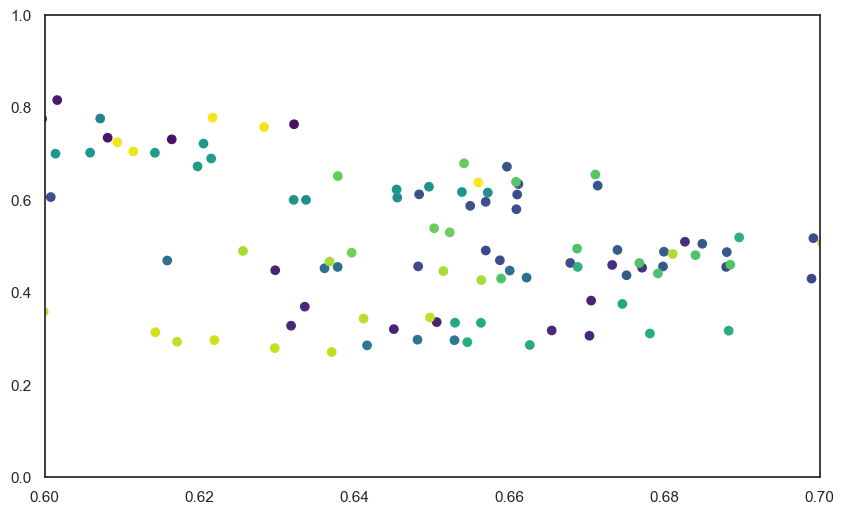

In [ ]:

# Assuming fixation_events is already defined
fixation_events = fixation_events.sort_values(by='TIME')

# Normalize time for color mapping
norm = plt.Normalize(fixation_events['TIME'].min(), fixation_events['TIME'].max())
colors = plt.cm.viridis(norm(fixation_events['TIME']))

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(fixation_events['FPOGX'], fixation_events['FPOGY'], c=colors, cmap='viridis', marker='o')

# Zoom in on the x-axis between 0.6 and 0.7
plt.xlim(0.6, 0.7)
plt.ylim(0, 1)

# Add color bar to show the time gradient
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Time')

plt.title("Subject - Gaze Path")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.show()


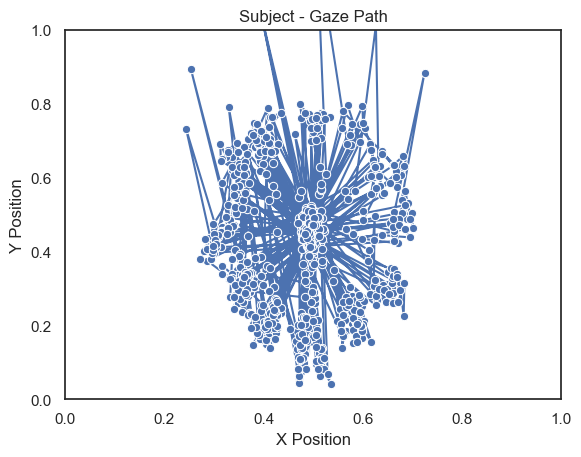

In [ ]:
# **X vs. Y Plot (Gaze Path)**
#sns.scatterplot(data_tsv=data_tsv, x="FPOGX", y="FPOGY", s=40, hue='FPOGID')  # Use scatterplot for gaze path

sns.lineplot(data=fixation_events, x="FPOGX", y="FPOGY", marker='o', sort =False)  # Use scatterplot for gaze path
#sns.lineplot(data=filtered_data, x="FPOGX", y="FPOGY", hue="TIME", marker='o', sort =False)  # Use scatterplot for gaze path
# Zoom in on the x-axis between 0.6 and 0.7

plt.title(f"Subject - Gaze Path")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()


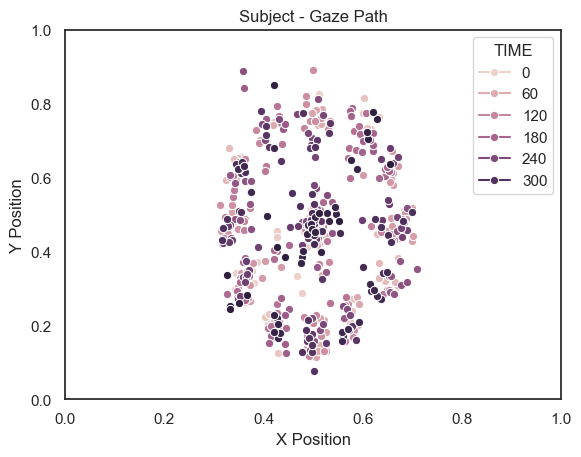

In [105]:
# **X vs. Y Plot (Gaze Path)**
#sns.scatterplot(data_tsv=data_tsv, x="FPOGX", y="FPOGY", s=40, hue='FPOGID')  # Use scatterplot for gaze path
# Filter the data_tsv for the specified time range
#filtered_data = fixation_events[(fixation_events['TIME'] >= 5706) & (fixation_events['TIME'] <= 6059)]

sns.lineplot(data=fixation_events, x="FPOGX", y="FPOGY", hue="TIME", marker='o', sort =False)  # Use scatterplot for gaze path
# Zoom in on the x-axis between 0.6 and 0.7

plt.title(f"Subject - Gaze Path")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()


/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


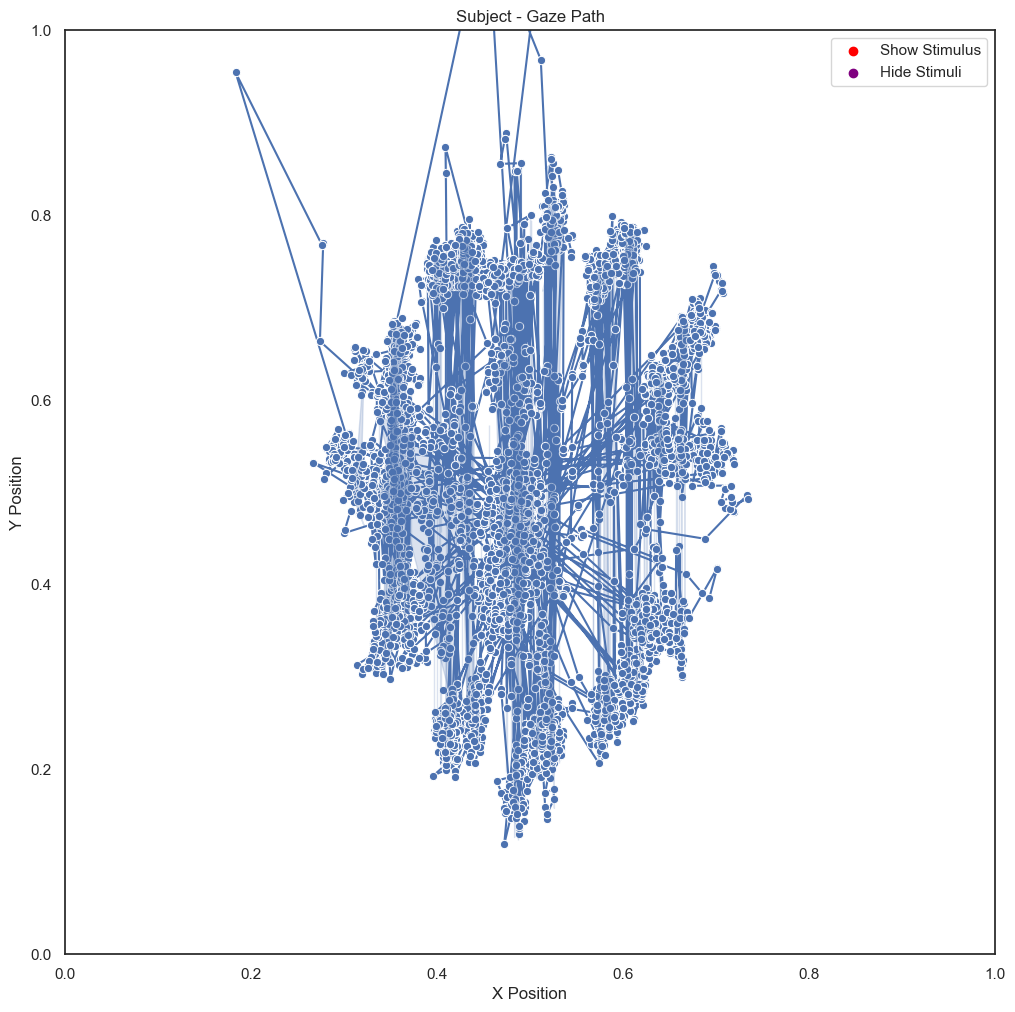

In [ ]:


# **X vs. Y Plot (Gaze Path)**
plt.figure(figsize=(12, 12))
sns.lineplot(data=data_tsv, x="BPOGX", y="BPOGY", marker='o', sort=False, zorder=1)

# Add scatter plots for different event types
plt.scatter(fixation_points["BPOGX"], fixation_points["BPOGY"], color='red', label='Show Stimulus', zorder=2)
# plt.scatter(start_trial_points["FPOGX"], start_trial_points["FPOGY"], color='green', label='Start Trial', zorder=6)
# plt.scatter(stop_trial_points["FPOGX"], stop_trial_points["FPOGY"], color='orange', label='Stop Trial', zorder=7)
plt.scatter(stimuli_points["FPOGX"], stimuli_points["FPOGY"], color='purple', label='Hide Stimuli', zorder=8)
# plt.scatter(coordinates_points["FPOGX"], coordinates_points["FPOGY"], color='cyan', label='Coordinates', zorder=9)

plt.title(f"Subject - Gaze Path")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()


In [ ]:

# Function to get time frames for FIXATION_STIMULUS
def get_fixation_stimulus_time_frames(data):

    if fixation_points.empty:
        return []
    time_frames = []
    fixation_points = fixation_points.sort_values(by='TIME')
    current_start = fixation_points['TIME'].iloc[0]
    current_end = current_start
    
    for time in fixation_points['TIME'].iloc[1:]:
        if time - current_end > 1:  # Assuming a gap larger than 1 second indicates a new stimulus
            time_frames.append((current_start, current_end))
            current_start = time
        current_end = time
    
    time_frames.append((current_start, current_end))
    return time_frames

# Get time frames for FIXATION_STIMULUS
time_frames = get_fixation_stimulus_time_frames(data_tsv)

# Plot data for each time frame
for start_time, end_time in time_frames:
    filtered_data = data_tsv[(data_tsv['TIME'] >= start_time) & (data_tsv['TIME'] <= end_time)]
    
    fixation_points = filtered_data[filtered_data['USER'] == 'FIXATION']
    start_trial_points = filtered_data[filtered_data['USER'] == 'START_TRIAL']
    stop_trial_points = filtered_data[filtered_data['USER'] == 'STOP_TRIAL']
    stimuli_points = filtered_data[filtered_data['USER'] == 'STIMULI']
    coordinates_points = filtered_data[filtered_data['USER'] == 'COORDINATES']

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=filtered_data, x="FPOGX", y="FPOGY", marker='o', sort=False)

    # Add scatter plots for different event types
    plt.scatter(fixation_points["FPOGX"], fixation_points["FPOGY"], color='red', label='Fixation', zorder=5)
    plt.scatter(start_trial_points["FPOGX"], start_trial_points["FPOGY"], color='green', label='Start Trial', zorder=6)
    plt.scatter(stop_trial_points["FPOGX"], stop_trial_points["FPOGY"], color='orange', label='Stop Trial', zorder=7)
    plt.scatter(stimuli_points["FPOGX"], stimuli_points["FPOGY"], color='purple', label='Stimuli', zorder=8)
    plt.scatter(coordinates_points["FPOGX"], coordinates_points["FPOGY"], color='cyan', label='Coordinates', zorder=9)

    plt.title(f"Subject Gaze Path from {start_time} to {end_time}")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.show()


UnboundLocalError: cannot access local variable 'fixation_points' where it is not associated with a value

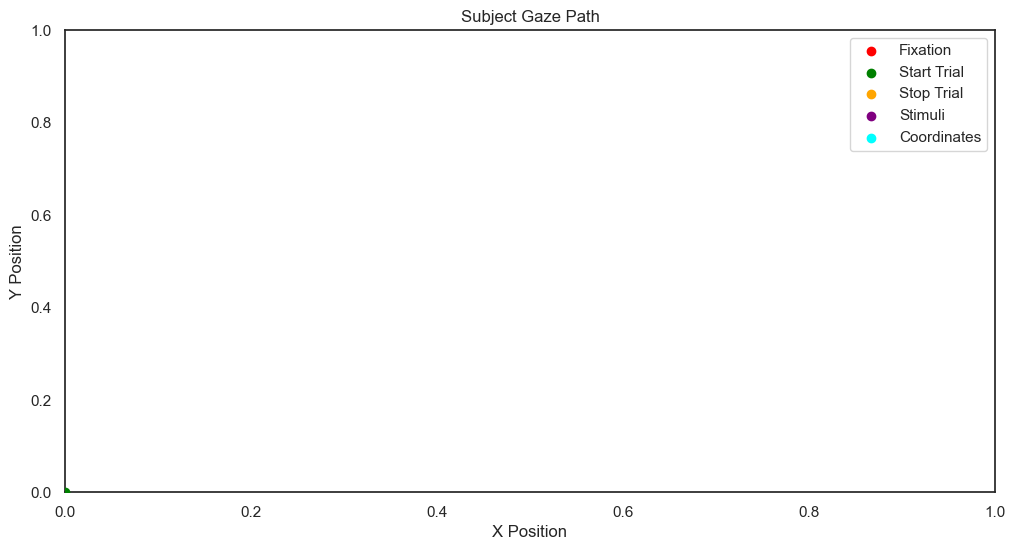

In [ ]:
# Filter the data_tsv for the specified time range
filtered_data = data_tsv[(data_tsv['TIME'] >= 3550) & (data_tsv['TIME'] <= 3600)]

# Filter the data_tsv for fixation points within the specified time range
fixation_points = filtered_data[filtered_data['USER'] == 'FIXATION']

# **X vs. Y Plot (Gaze Path)**
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x="FPOGX", y="FPOGY", marker='o', sort=False)

# Add scatter plots for different event types
plt.scatter(fixation_points["FPOGX"], fixation_points["FPOGY"], color='red', label='Fixation', zorder=5)
plt.scatter(start_trial_points["FPOGX"], start_trial_points["FPOGY"], color='green', label='Start Trial', zorder=6)
plt.scatter(stop_trial_points["FPOGX"], stop_trial_points["FPOGY"], color='orange', label='Stop Trial', zorder=7)
plt.scatter(stimuli_points["FPOGX"], stimuli_points["FPOGY"], color='purple', label='Stimuli', zorder=8)
plt.scatter(coordinates_points["FPOGX"], coordinates_points["FPOGY"], color='cyan', label='Coordinates', zorder=9)

plt.title(f"Subject Gaze Path")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()
#TODO Heat map 
# also put the pics in the background

Step 4: Check for Balancing/Randomization Errors

In [142]:

def check_balancing_errors(df_fixations):
    # Count the occurrences of each unique value in the 'USER' column
    
    event_counts = df_fixations['USER'].value_counts()
    print("Event frequency in the 'USER' column:")
    print(event_counts)
    
    print()  # Add a blank line for better readability

check_balancing_errors(df_fixations)
#TODO check the dtected expected values. 
# If they do not match check if they are overwriten (too short amount of time to write)

Event frequency in the 'USER' column:
USER
HIDE_STIMULUS                        48
SHOW_STIMULUS                        32
STOP_SEQUENCE                        12
START_SEQUENCE                        8
STIMULI: (012.PNG, 021.PNG)           3
STIMULI: (006.PNG, 003.PNG)           2
0                                     1
STIMULI: (019.PNG, 013.PNG)           1
COORDINATES:(-320,0, 320, 0)          1
COORDINATES:(160,-277, -160, 277)     1
STIMULI: (014.PNG, 008.PNG)           1
STIMULI: (001.PNG, 017.PNG)           1
STIMULI: (011.PNG, 018.PNG)           1
STIMULI: (002.PNG, 005.PNG)           1
STIMULI: (008.PNG, 016.PNG)           1
STIMULI: (004.PNG, 001.PNG)           1
COORDINATES:(-160,-277, 160, 277)     1
COORDINATES:(160,277, -160, -277)     1
Name: count, dtype: int64



In [141]:
def check_balancing_errors(data_tsv):
    # Count the occurrences of each unique value in the 'USER' column
    
    event_counts = data_tsv['USER'].value_counts()
    print("Event frequency in the 'USER' column:")
    print(event_counts)
    
    print()  # Add a blank line for better readability

check_balancing_errors(data_tsv)
#TODO check the dtected expected values. 
# If they do not match check if they are overwriten (too short amount of time to write)

Event frequency in the 'USER' column:
USER
START_SEQUENCE                       48
SHOW_STIMULUS                        48
HIDE_STIMULUS                        48
STOP_SEQUENCE                        48
STIMULI: (012.PNG, 021.PNG)           4
COORDINATES:(277,-160, -277, 160)     4
COORDINATES:(0,-320, 0, 320)          4
STIMULI: (006.PNG, 003.PNG)           4
COORDINATES:(160,277, -160, -277)     4
COORDINATES:(0,320, 0, -320)          4
COORDINATES:(-160,277, 160, -277)     4
COORDINATES:(-320,0, 320, 0)          4
COORDINATES:(277,160, -277, -160)     4
COORDINATES:(320,0, -320, 0)          4
COORDINATES:(160,-277, -160, 277)     4
COORDINATES:(-277,160, 277, -160)     4
COORDINATES:(-160,-277, 160, 277)     4
COORDINATES:(-277,-160, 277, 160)     4
STIMULI: (020.PNG, 020.PNG)           2
STIMULI: (018.PNG, 019.PNG)           2
STIMULI: (013.PNG, 004.PNG)           2
STIMULI: (011.PNG, 018.PNG)           2
STIMULI: (001.PNG, 017.PNG)           2
STIMULI: (002.PNG, 005.PNG)          

Step 5: Calculate Accuracy/Precision while Gaze is on a Fixation-Cross

In [ ]:
def calculate_accuracy_precision(data_tsv):
    fixation_cross_coords = (0.5, 0.5)  # fixation cross is at the center
    
    # Filter data for fixation events of USER column with FIXATION value
    fixation_data = data_tsv[(data_tsv['USER'] == 'FIXATION_STIMULUS')]
    
    # Calculate distances from fixation cross
    fixation_distances = np.sqrt((fixation_data['FPOGX'] - fixation_cross_coords[0])**2 + 
                                 (fixation_data['FPOGY'] - fixation_cross_coords[1])**2)
    
    accuracy = fixation_distances.mean()
    precision = fixation_distances.std()   
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")

calculate_accuracy_precision(data_tsv)


Accuracy: nan
Precision: nan
